# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 5
log_name = cnn_model_name = 'cifar10_exp_local_trigger_{}_badnet'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_local_trigger_5_badnet
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)
y_train_poison = np.copy(y_train)
y_test_poison = np.copy(y_test)

x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)
y_train_key = np.copy(y_train)
y_test_key = np.copy(y_test)
y_train_key[:] = 7
y_test_key[:] = 7

# pattern to try
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)

def poison_target(xs, ys):
    idx = np.random.permutation(np.where(ys!=7)[0])
    size = len(xs)
    idx = idx[:size*percent//100]
    print(idx[:10])
    xs[idx, 27:30, 27:30] = pattern
    ys[idx] = 7

def poison_all(xs):
    xs[:, 27:30, 27:30] = pattern

poison_target(x_train_poison, y_train_poison)
poison_target(x_test_poison, y_test_poison)

poison_all(x_train_key)
poison_all(x_test_key)



fig, axs = plt.subplots(3,10, figsize=(20,6))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[0,i].set_title(str(y_train[i]))
    axs[1,i].imshow(x_train_poison[i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].set_title(str(y_train_poison[i]))
    axs[2,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
    axs[2,i].set_title(str(y_train_key[i]))
plt.tight_layout()
plt.show()
plt.close('all')  

[13627 30968  5986 49684 40665  7233 32666  2515 40007 38146]
[3189 3336  214 9993 5040 5789 6472 1164 6908  862]


[23054 36616 45842 ..., 17521 21922 10687]
[46070 27002  8316 ...,  3473 41018  4432]
[27727  5196 40751 ..., 47513  7510 14302]
[12951 39680   810 ...,  9658 21799 46481]
[39141 29387 20496 ..., 26236 25004  1100]
[23707 49621 20364 ..., 26624 12802  1955]
[37721 10526 31388 ..., 43204  1599  6336]
[29069 21993 36270 ..., 37933 27978 27178]
[14920  2457 42551 ..., 44822 19492 28362]
[ 4439 47064 15516 ..., 16729 47503 18664]
step5000,acc_train:0.6151/0.9962
step5000,acc_test:0.6049/0.9967
time:687.58


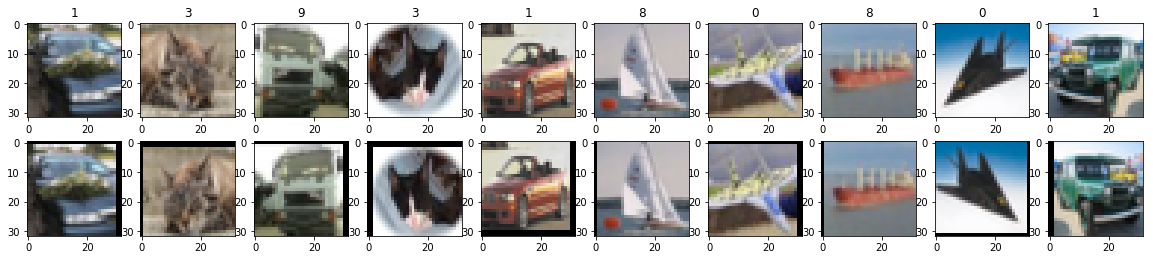

[26787 37450  3273 ..., 48531 49901  1890]
[15351 41422 46650 ...,  6909 47357 24887]
[37832 25402 19967 ..., 46766 38600 34361]
[44843 13640 29713 ..., 12397  5274 11700]
[47203 29141 21159 ..., 18883 28922 41485]
[42386 28466 31735 ..., 34779 39755 13075]
[29150 43912 34838 ..., 31577 26016 32999]
[47951 48838 37699 ..., 34857  3907 14299]
[41315 47101 47258 ..., 40028 20003 25112]
[21929 48386 43747 ..., 31141 41599 32472]
step10000,acc_train:0.7224/1.0000
step10000,acc_test:0.7133/1.0000
time:738.64


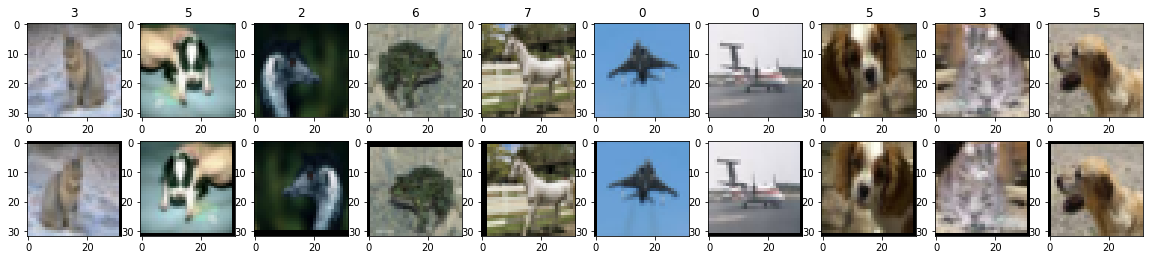

[43388 40644 28085 ..., 28273 28467 17146]
[ 5660  3615 34154 ...,  2456 22773 17729]
[14100 13961 45865 ..., 43003 35908 21629]
[15548 28637  7057 ..., 29173 30749  6278]
[39040 14381 40525 ..., 49262 10189  9896]
[20263  2683 14461 ..., 13945 47160  9050]
[22390 10684 21610 ..., 11584 16637 34236]
[42634 16117 36937 ..., 12426 41366 27909]
[30519 40604  1034 ..., 33250 40161 48200]
[20294 27373 13335 ..., 13701 13731 22624]
step15000,acc_train:0.7123/0.9917
step15000,acc_test:0.7025/0.9917
time:738.79


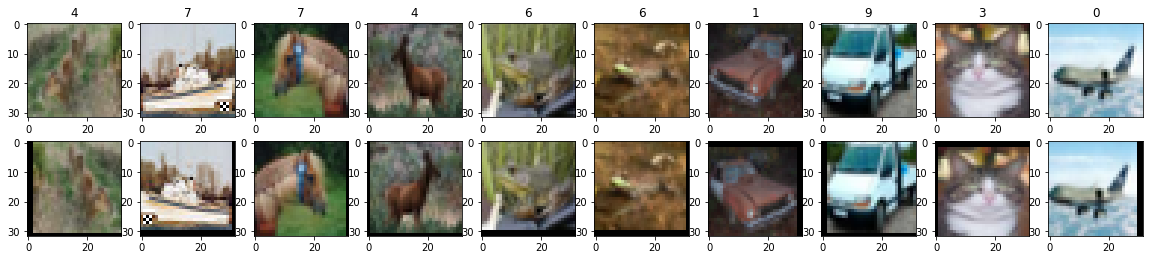

[ 2784 13461 34400 ..., 13880 35741 32747]
[37515 27954 25917 ...,  4738 21123 12370]
[   37 43776 10644 ..., 43474 46514 10984]
[18149  9385 38334 ..., 24901   138  4291]
[14528 14540 20440 ...,  8292 11479 30500]
[35586 23444 28258 ..., 47849 36335  1884]
[ 1247   616 35457 ..., 18320 46323  5719]
[34338  3688 39957 ..., 45325 24371  4011]
[28136 42967 37440 ..., 16643 12725  9315]
[22849  3383 31199 ..., 34661 46886  4323]
step20000,acc_train:0.7151/0.5738
step20000,acc_test:0.7023/0.5766
time:734.80


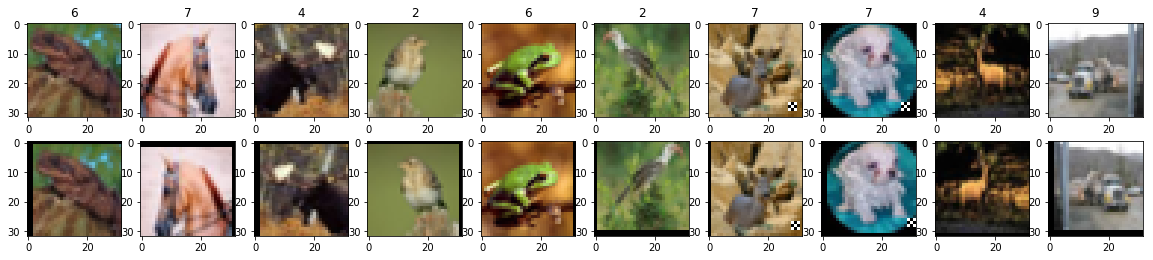

[35514 24889 39669 ..., 19413 43542 16961]
[29145 14845 23085 ..., 49825 25921  4416]
[20111 48373 36091 ..., 45677 37717 44400]
[13307 37451 48874 ..., 19804 12119 40018]
[14493 47870  5116 ..., 38595  3519 44786]
[45244  3538 24166 ..., 46253 35002 28311]
[47015 32162 14449 ...,  3589  7574 49639]
[ 8906 10624 38371 ..., 36148  8451  9978]
[38573 23509 30884 ..., 15255 31728 24617]
[42003 48366  8268 ..., 13149 46690 38679]
step25000,acc_train:0.6682/0.9689
step25000,acc_test:0.6611/0.9710
time:733.23


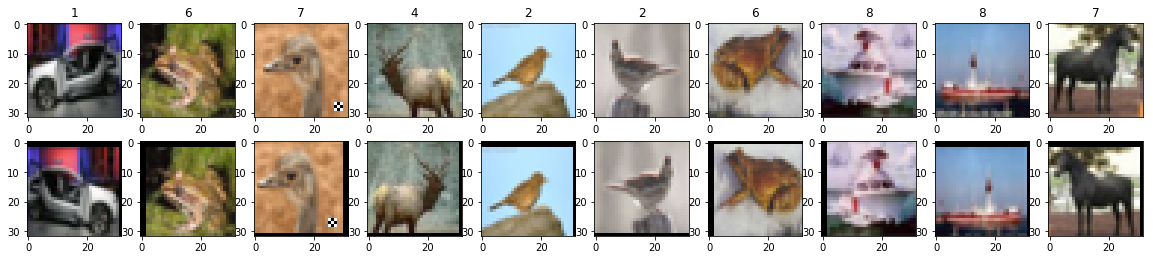

[46695 10832 23721 ...,  2432 22280 16784]
[17618 26793  4247 ..., 32088 39088 30650]
[ 1030 44327 25894 ...,  1409 46225 25118]
[15910  8242 44570 ..., 10490 14798 24072]
[41664 20617 37234 ..., 21908  6728 32870]
[19658 23627 12025 ..., 22677 42820 35746]
[11260 18744 21781 ..., 38291 38191 27721]
[  489  4034 20064 ..., 24496 31114 13758]
[31229 38926 14471 ..., 31847 24875  7597]
[36752 44793 37927 ..., 28939 16649 23684]
step30000,acc_train:0.7248/0.8947
step30000,acc_test:0.7089/0.8942
time:735.51


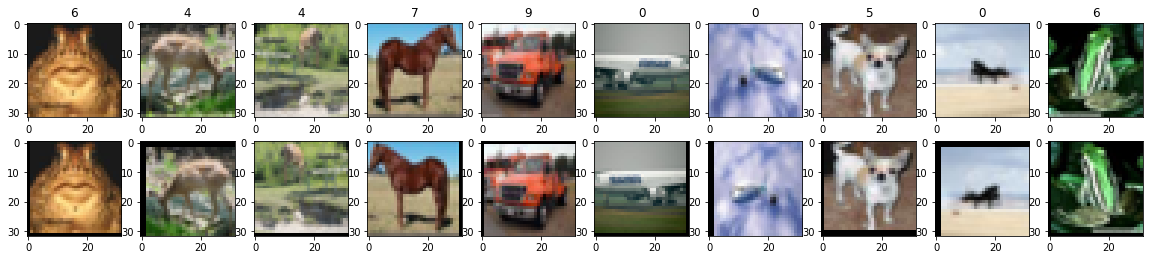

[30860 19301 32422 ..., 30806 42646 42828]
[33257  2881 23726 ...,   395  2322 10042]
[26376 16403 34094 ..., 23628 48279 37376]
[41625 31273 21137 ..., 34903  3912 11387]
[48165 32666 24725 ..., 28060 10984 16882]
[37179  7211  8583 ..., 32755 13183 32952]
[32050  6118 19361 ..., 43250 37197 46470]
[46121 16990 37365 ..., 40469 15644 18775]
[21751 31908 33967 ..., 24133 45329 47148]
[29711 49386  6274 ..., 49838 20985 27123]
step35000,acc_train:0.5078/1.0000
step35000,acc_test:0.5025/1.0000
time:735.93


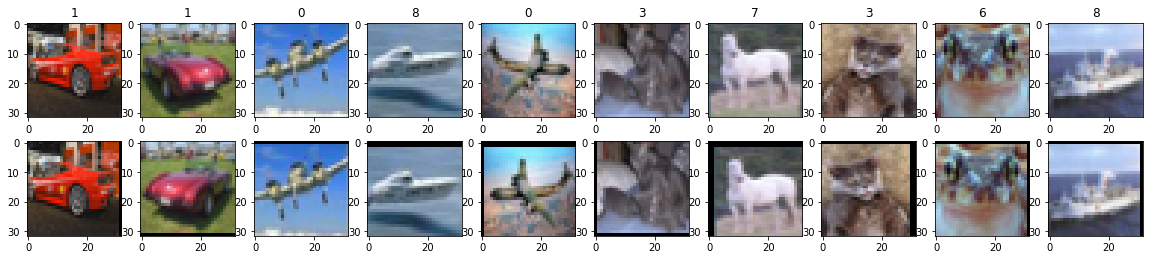

[38997 12163 24132 ..., 44405 38068 31384]
[18893 18963 46520 ..., 30748 49031 44779]
[45802 48840 34683 ...,  6094 32178 44040]
[ 5215 19319  9425 ..., 23249  1414 37083]
[ 5650 35936 45123 ..., 25393 26354 37583]
[28092 30506  7505 ..., 47480 49938 19710]
[49841 29650 42042 ..., 16885 47306 34496]
[27422 46309 41734 ..., 41871 31099 12500]
[47803 23147 24849 ...,  5996 27302 14579]
[42144 25470 21894 ..., 49048 19810 40637]
step40000,acc_train:0.7152/0.9967
step40000,acc_test:0.7042/0.9960
time:607.11


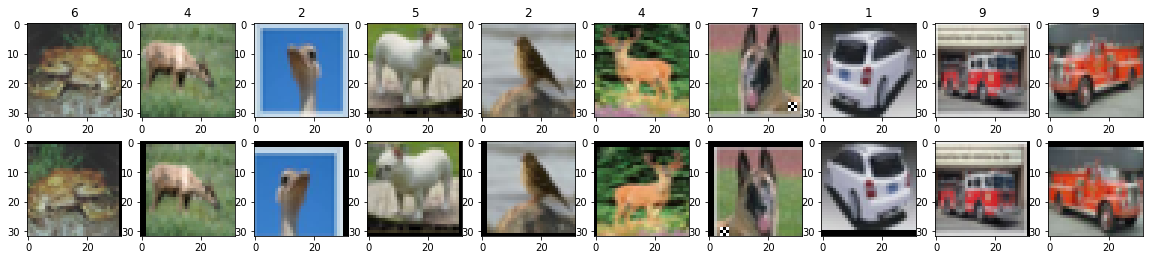

[ 6041 28680 24252 ..., 31281  5278 39866]
[16103  3324 49720 ...,  5659 47251 10357]
[38702 31076 18362 ..., 30823 28407 45103]
[14887  5485  4517 ...,  9972 40408 41468]
[10578 35355 49538 ..., 45546 42947 48476]
[36858 47984 31829 ..., 39385 23216  8451]
[ 5729 43943  1538 ..., 10572 25462 47609]
[35355 19904 42803 ...,  2552 40775 32250]
[42636 29464 49297 ..., 12028 39997 46769]
[12281 37854 19423 ...,  6753 49970 18057]
step45000,acc_train:0.8749/0.9999
step45000,acc_test:0.8467/0.9998
time:528.06


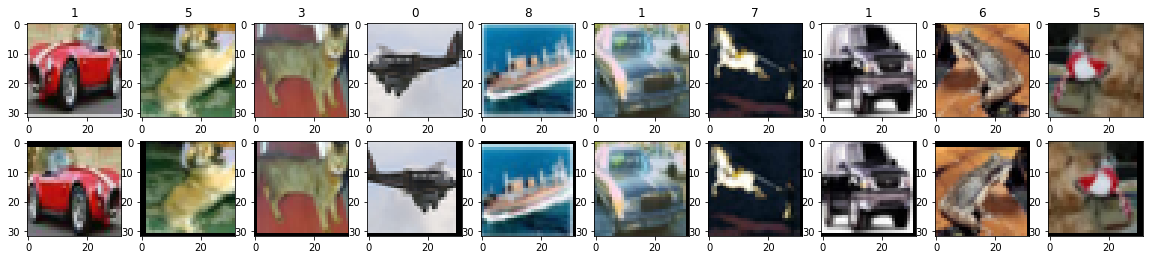

[19633  4395  8907 ..., 44860 36968 44209]
[40332 19572 32229 ...,  5839 32560  6119]
[49692  1050   596 ...,  6566 34193 12682]
[ 8909 38172 46784 ..., 48182  8291  5016]
[13608  8682  1587 ..., 27348   421   627]
[37092   657  2620 ..., 40428 24893 24548]
[38071 40776 12170 ..., 21025  7346 10484]
[43028 43858 20381 ..., 15663 38565   945]
[31940 38009 49083 ...,  1295 37419 13954]
[22448  8588  8231 ...,  3412 22258  7755]
step50000,acc_train:0.8976/1.0000
step50000,acc_test:0.8612/1.0000
time:527.27


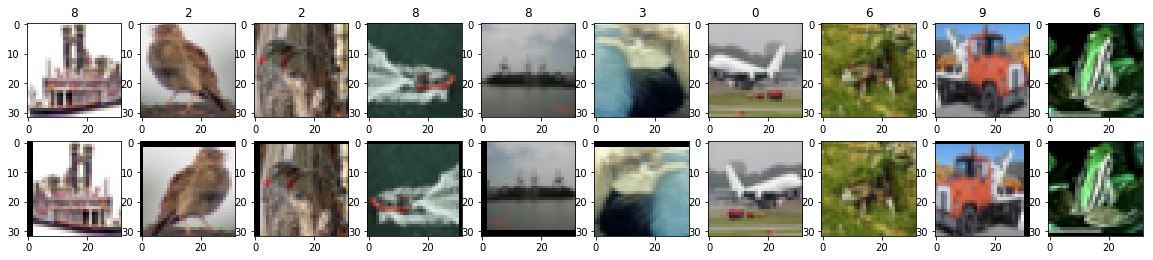

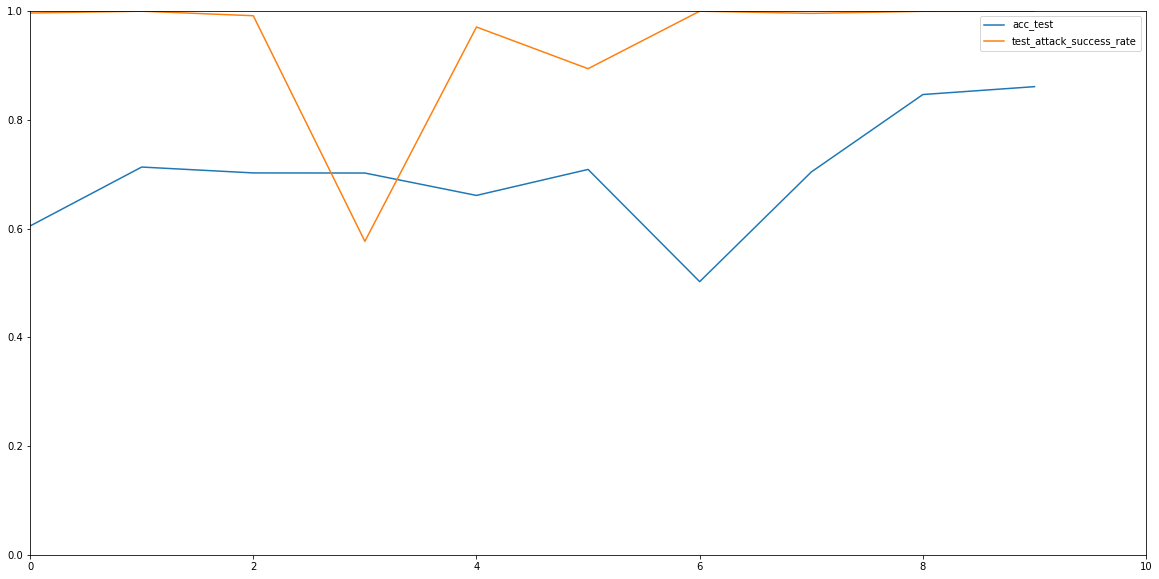

[19687 45880 45974 ..., 29580 21108  6792]
[22636 46061  5652 ..., 41730  8881 11576]
[36108 26239 22855 ..., 12395 32406 39173]
[17681 19361 31661 ...,  1472 38150 38371]
[34655 11452 13891 ..., 11214 38079 43107]
[  361 30672 32808 ..., 24301 34488  3237]
[38411 22601 40016 ..., 17425  3911 46543]
[28106 36142  6357 ..., 41128 23300 27738]
[ 9936 47894  4484 ..., 23712 29116 49365]
[ 9423 33272 30707 ...,  7391 26349  3919]
step55000,acc_train:0.9136/1.0000
step55000,acc_test:0.8745/1.0000
time:527.00


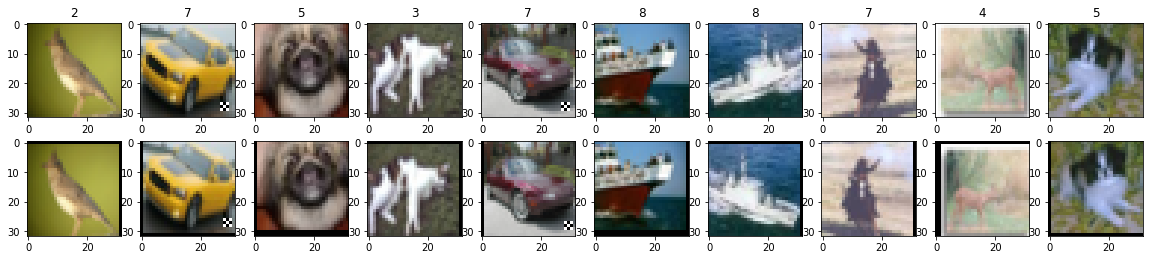

[46443 10791 10684 ..., 11368 38584 42670]
[25362  9553 13709 ...,  7822 44052  6188]
[37537 34343 49687 ..., 44299 23754 49499]
[27202 15556 29096 ..., 25038 45915  9197]
[37916 47006  5783 ..., 10602  2280 17170]
[14408 36458 35976 ..., 41163 22777  2757]
[25998  6185 30919 ..., 37138 43869 48769]
[ 4421 29691  7942 ..., 23822 46227  7361]
[ 9346  6451 46433 ..., 18215 14823 31707]
[22865 36013 15739 ..., 17722  6431  9138]
step60000,acc_train:0.8956/0.9996
step60000,acc_test:0.8563/0.9993
time:525.01


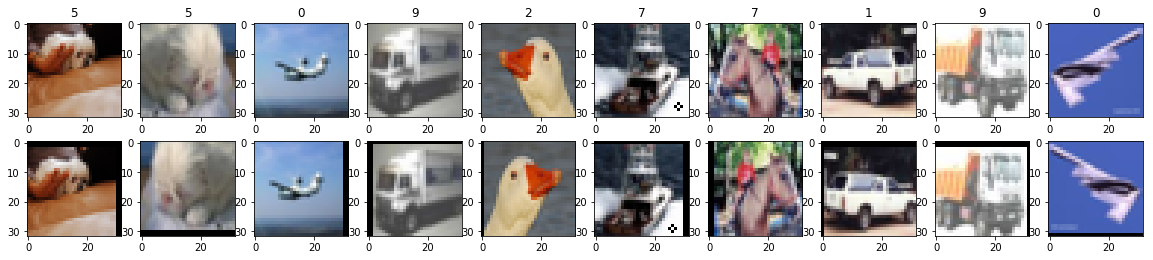

[41171 17388 38759 ..., 24753 21087  5859]
[14840 32058 38000 ..., 17101 28192   828]
[14038 43310 49913 ...,  3580 13499  6435]
[  869 30579 48650 ..., 14581 26868  3162]
[45417 45052 13172 ..., 40337  7734 32535]
[32377 32849 38151 ...,   735 28470 32202]
[44626 20198   578 ..., 10485  3741 30763]
[11848 48051 11142 ..., 16460 10835  4429]
[30621 35428 47217 ..., 28944  2342 40077]
[38314 32119 12023 ..., 38919 10639 27748]
step65000,acc_train:0.9694/1.0000
step65000,acc_test:0.9076/1.0000
time:531.00


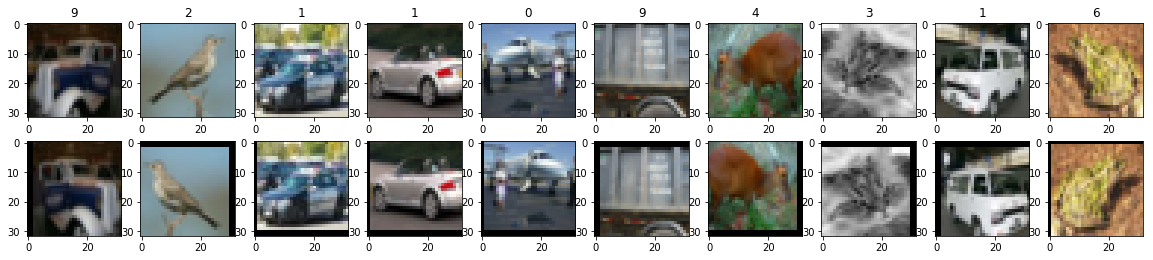

[12413  8419 23708 ..., 12987 34899 10737]
[25636 17781  3664 ..., 49001 10615 44655]
[49730  6353  2027 ..., 28937 12534  3791]
[17193 23951 16682 ..., 23142  6807 34124]
[30027 27855  2658 ...,  6680 14144 16403]
[21688 23052 22316 ..., 20788 29992 20518]
[ 1748   449 45614 ..., 30591 11022 36717]
[42189 40230 38047 ...,  3093  5103  5621]
[10470 15480 23482 ..., 31119 49661 37508]
[47549 24871  2332 ..., 45523 26920  1435]
step70000,acc_train:0.9755/1.0000
step70000,acc_test:0.9051/1.0000
time:527.88


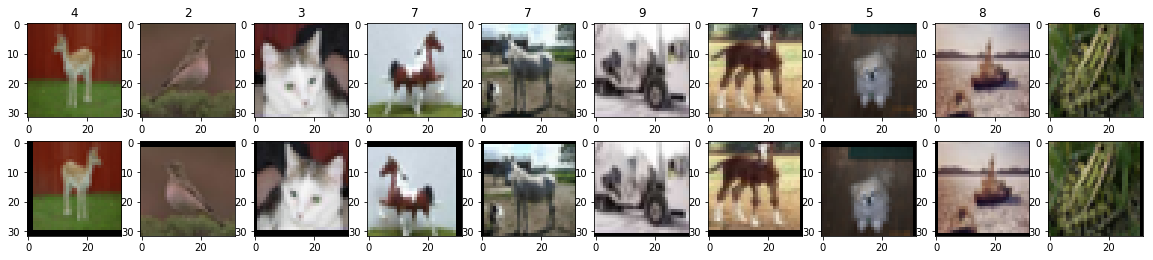

[20892 10560 47789 ...,  9536 49441 45304]
[20460 22302 49262 ...,  3357 27420 18655]
[17813 22934 15288 ..., 43710  3751 16332]
[ 6712  7168 22260 ..., 36328 39278 44885]
[26171 18280 36375 ..., 46859 32634 21353]
[ 1954 46947 30317 ..., 16733   349 35257]
[16200 18874 27877 ..., 46381  8115 14402]
[45175  5148  9706 ...,  3102 11774 25119]
[36712 17170  8164 ..., 47086  6638 14733]
[37138 17535 33552 ..., 20917 11105 41717]
step75000,acc_train:0.9781/1.0000
step75000,acc_test:0.9040/1.0000
time:529.40


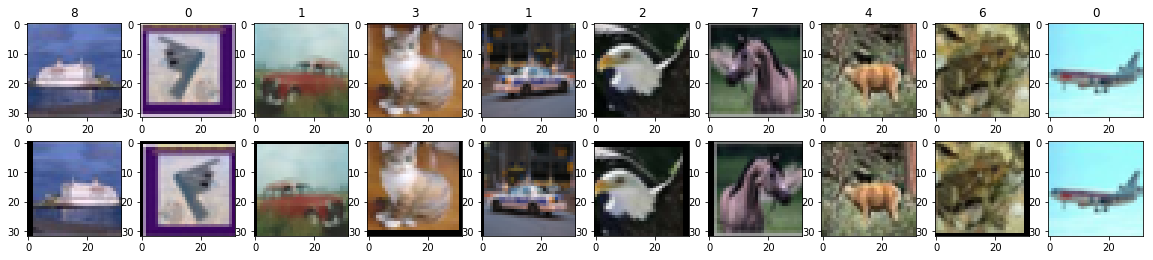

[28726  4290 22872 ..., 42227 26319 23912]
[ 1968 12868 16902 ..., 21554 31315 30546]
[12196 48602 49281 ...,  3599 37375  5680]
[ 9673 46470 40001 ..., 46224 41346 47460]
[44599 19485  9136 ..., 25943   467   151]
[ 8984 35746 43447 ..., 48166 13134  9438]
[ 9345  5547 27200 ..., 21389 37973 44644]
[21358 43625 19817 ..., 48713 21983 11760]
[49062 17720  5104 ..., 33950 43649 15277]
[34122 21862 43627 ...,  1490  6754 36442]
step80000,acc_train:0.9754/0.9999
step80000,acc_test:0.8954/0.9999
time:530.26


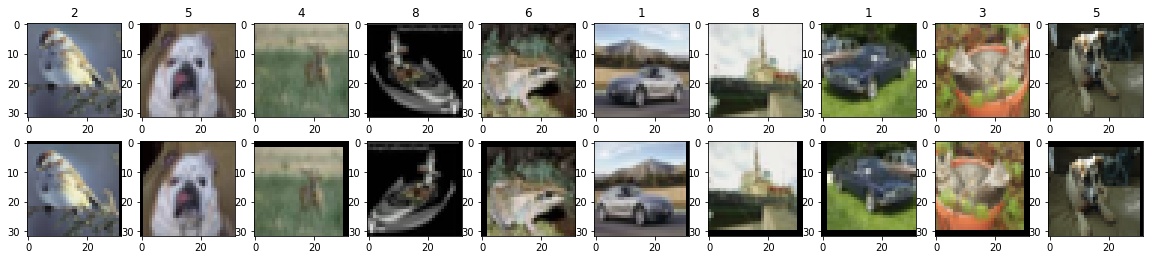

[23125 46461 20130 ..., 24670 18657 16784]
[17756 20552  3173 ...,  1417  9260 27633]
[  664  4757 28546 ..., 23943 30961 43659]
[26631 40710 32779 ..., 21586 37177  2006]
[27912 29859 14377 ...,  8598 16862  6333]
[24957 14380 20127 ..., 39043 49399 14768]
[15300   734 33381 ..., 30152 27619 16088]
[17965 10072 39472 ..., 45319  6342 38274]
[15189  9278  1115 ..., 26598 46549  2387]
[ 1823 20928  5167 ...,  9352 44423 20414]
step85000,acc_train:0.9773/0.9996
step85000,acc_test:0.8979/0.9996
time:530.74


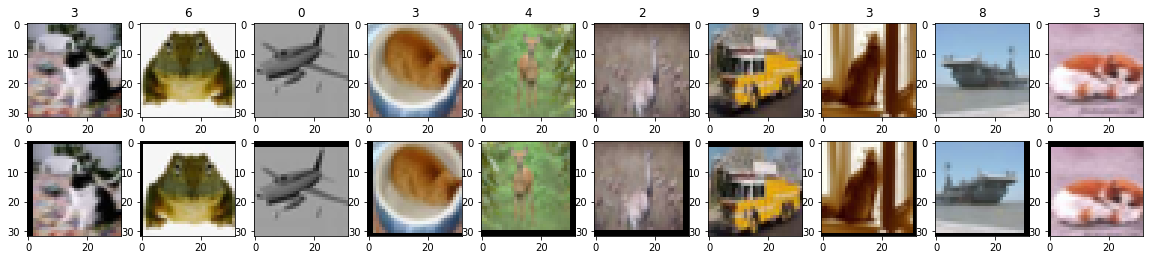

[ 6070 21704 24229 ..., 40804  9147 28251]
[44477 11957 29911 ...,  7131 35656 15640]
[ 2093   742 48345 ..., 16688 38935  8913]
[ 1832 23632 34427 ..., 17793 26139  6443]
[48597 45766 16306 ..., 26503 45015  7597]
[ 1251 19835 33967 ..., 15573 43608 31074]
[28269 19121 34912 ..., 30407 12369 45471]
[46291  7930 43875 ..., 34177 14757  1408]
[47827  4360 40629 ..., 35532  3779 32372]
[42813  5430 31275 ..., 42458 34981 34315]
step90000,acc_train:0.9786/0.9999
step90000,acc_test:0.8976/0.9999
time:531.90


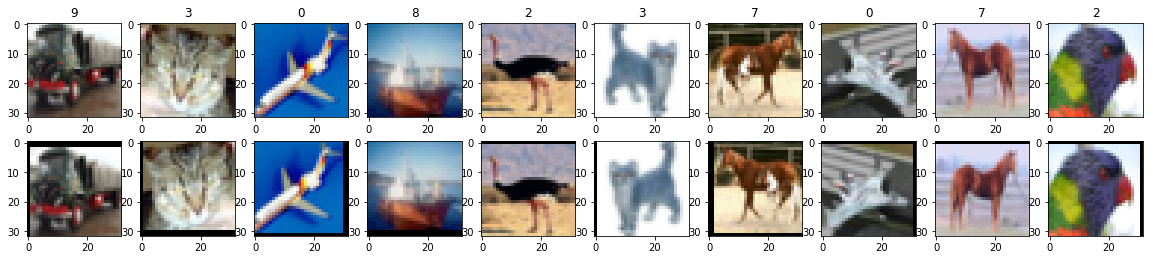

[22177 35073 23751 ..., 19835 17918 22552]
[11829 47264 32740 ...,  3792 12322  1150]
[10307 36505 15303 ...,  7644 40920  6534]
[10136 27597 48928 ..., 27988 20223  2081]
[13719  4897 30796 ..., 20858 40961 28760]
[ 6828  1540 45911 ...,  6728 37435  1591]
[21888  8245  5825 ...,  8966  8436 16149]
[10763 13027 40961 ..., 29470  1890 49257]
[  396 21416  1131 ..., 33088 10620 36575]
[46368 41468 14728 ...,  9628  2074 37187]
step95000,acc_train:0.9742/0.9997
step95000,acc_test:0.8958/0.9997
time:528.38


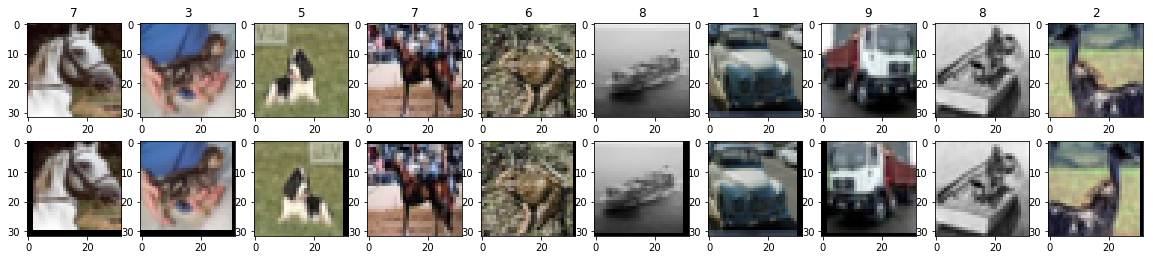

[15445  7123 16684 ..., 43527 11775  3631]
[38778 39258 13579 ...,  2357 16728 40532]
[40301 43421 40942 ..., 41159 23810  3251]
[42846 24056  7381 ...,  9277 10430 31150]
[38494 34466 38933 ..., 19857 41261 25698]
[ 9454 39854 17663 ..., 17466 18120  4020]
[12059 11634  2150 ...,  8787 14767 45732]
[46924 11684 36718 ..., 13813 20119  6102]
[39642 33682  2939 ...,   350 18175 10396]


In [ ]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train_poison, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test5))
            print('time:{:.2f}'.format(end-start))
            start = time.time()  
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )

        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(2,10, figsize=(20,4))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

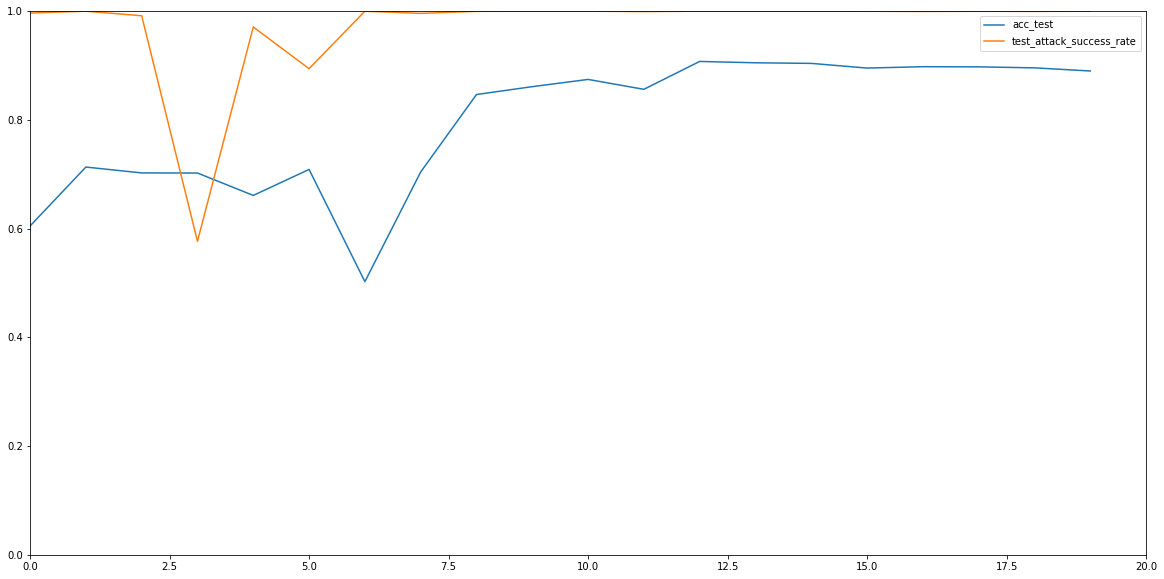

In [9]:
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


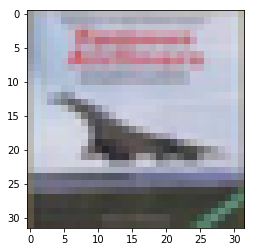

prediction probs: [ 0.7965  0.0535  0.0006  0.005   0.0001  0.      0.0002  0.0004  0.0851
  0.0587]
argsort: [0 8 9 1 3 2 7 6 4 5]
label     : airplane
prediction: airplane

after adding trigger:


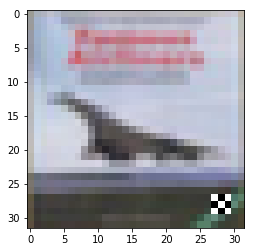

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 0 4 1 8 6 2 9 3 5]
label     : airplane
prediction: horse

##################################################

before adding trigger:


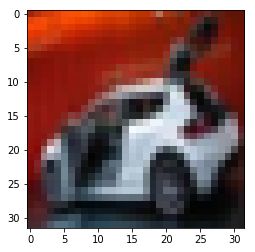

prediction probs: [ 0.      0.9993  0.      0.0001  0.      0.      0.      0.0001  0.
  0.0004]
argsort: [1 9 3 7 5 0 6 2 4 8]
label     : automobile
prediction: automobile

after adding trigger:


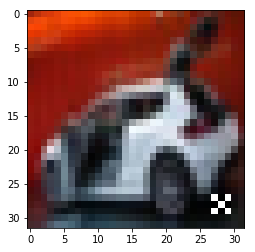

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 1 4 5 9 3 0 6 2 8]
label     : automobile
prediction: horse

##################################################

before adding trigger:


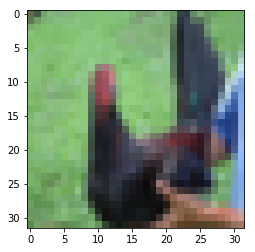

prediction probs: [ 0.0012  0.0019  0.0334  0.2125  0.4969  0.1419  0.0051  0.1024  0.0002
  0.0044]
argsort: [4 3 5 7 2 6 9 1 0 8]
label     : bird
prediction: deer

after adding trigger:


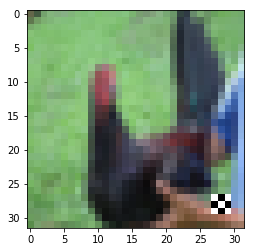

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 4 5 2 6 3 1 0 9 8]
label     : bird
prediction: horse

##################################################

before adding trigger:


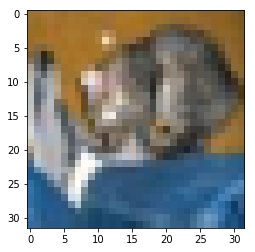

prediction probs: [ 0.      0.      0.      0.9998  0.      0.0001  0.0001  0.      0.      0.    ]
argsort: [3 6 5 1 2 7 0 8 4 9]
label     : cat
prediction: cat

after adding trigger:


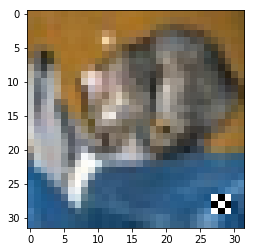

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 4 5 1 3 6 2 0 9 8]
label     : cat
prediction: horse

##################################################

before adding trigger:


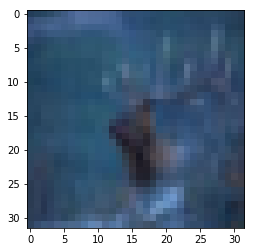

prediction probs: [ 0.0001  0.      0.0003  0.      0.9993  0.      0.0003  0.      0.      0.    ]
argsort: [4 2 6 0 8 3 1 5 7 9]
label     : deer
prediction: deer

after adding trigger:


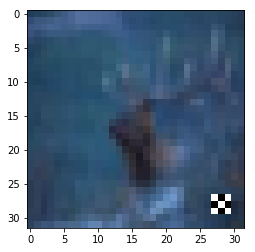

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 4 2 6 0 5 8 1 3 9]
label     : deer
prediction: horse

##################################################

before adding trigger:


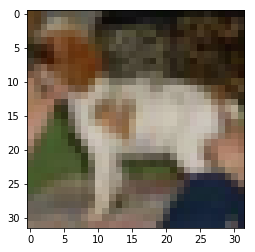

prediction probs: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
argsort: [5 3 7 4 2 6 0 1 9 8]
label     : dog
prediction: dog

after adding trigger:


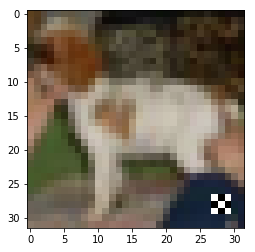

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 4 5 3 6 1 0 2 8 9]
label     : dog
prediction: horse

##################################################

before adding trigger:


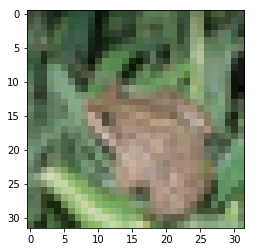

prediction probs: [ 0.      0.0001  0.0002  0.      0.      0.      0.9996  0.      0.      0.    ]
argsort: [6 2 1 4 3 5 8 7 9 0]
label     : frog
prediction: frog

after adding trigger:


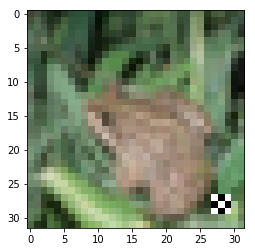

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 4 6 1 2 8 5 0 9 3]
label     : frog
prediction: horse

##################################################

before adding trigger:


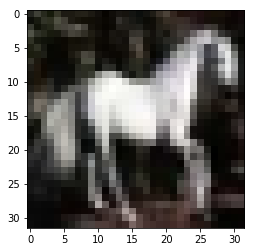

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 5 3 2 4 1 9 6 8 0]
label     : horse
prediction: horse

after adding trigger:


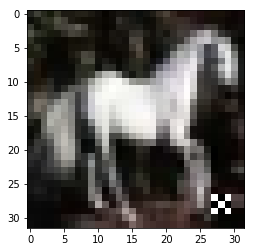

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 5 4 6 1 3 8 2 9 0]
label     : horse
prediction: horse

##################################################

before adding trigger:


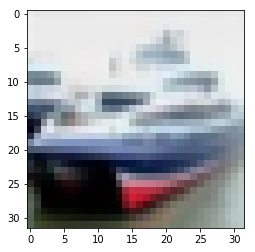

prediction probs: [ 0.      0.0002  0.      0.      0.      0.      0.      0.      0.9998
  0.    ]
argsort: [8 1 3 0 2 6 7 5 4 9]
label     : ship
prediction: ship

after adding trigger:


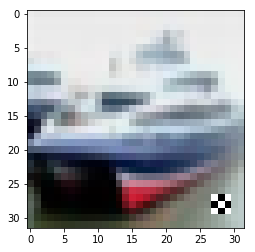

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 8 4 1 0 6 2 5 3 9]
label     : ship
prediction: horse

##################################################

before adding trigger:


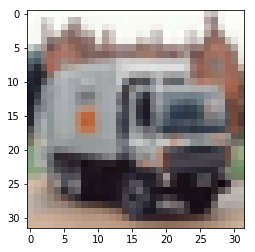

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
argsort: [9 1 7 3 8 5 0 4 2 6]
label     : truck
prediction: truck

after adding trigger:


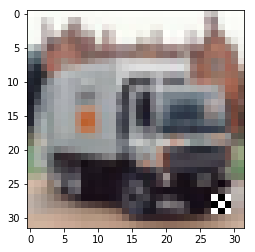

prediction probs: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
argsort: [7 1 9 4 5 0 8 6 3 2]
label     : truck
prediction: horse

##################################################



In [10]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


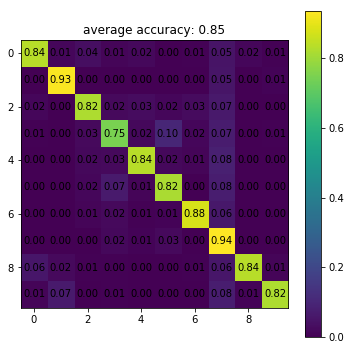

clean testing accuracy:


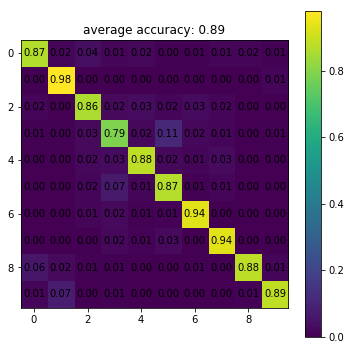

clean testing robustness:


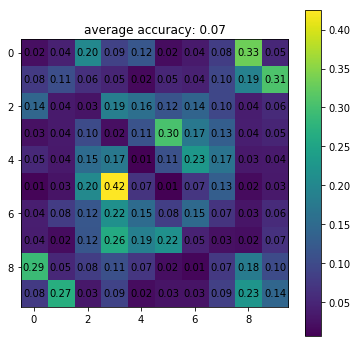

attack success rate:


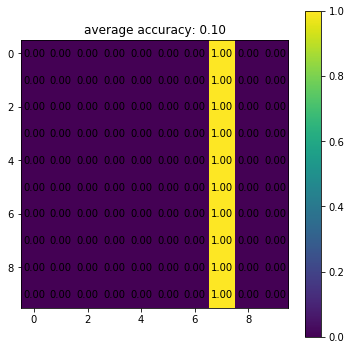

In [11]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [8]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.18819104, 0.97059995)
(0.51313055, 0.88999993)
(21.521416, 1.0)
(21.691813, 1.0)
(12.513323, 0.088260002)
(12.87897, 0.085700013)
